Objective: To design a lightweight 3D U-Net model suitable for low-resource systems.  (Learn visually: Watch the tutorial video for this section.)
4.1
      A. Introduction to 3D U-Net 
The 3D U-Net architecture is a powerful model for medical image segmentation tasks, particularly for volumetric data like brain MRI scans. It extends the traditional 2D U-Net by incorporating a third spatial dimension, enabling the model to capture 3D contextual information. This is especially important for
tasks like brain tumour segmentation, where tumours can span multiple slices in a 3D volume.
 
However, 3D U-Net models can be computationally expensive, making them challenging to run on low-resource systems (e.g., normal CPUs). To address this, we make several modifications to create a lightweight 3D U-Net:  
- Fewer Layers: Reducing the number of convolutional layers to decrease
model complexity.  
- Smaller Filters: Using fewer filters in each convolutional layer to
reduce memory usage.  
- Efficient Patch Extraction: Processing smaller 3D patches instead of the
entire volume to fit within memory constraints. 
4.2
       B. Model Implementation  
The code for the implementation of the 3D U-Net model was referenced from Sreenivas [Bhattiprolu, n.d.] who converted his 2D U-Net to a simple 3D U-Net model. The 3D U-Net uses 3D convolutions to process volumetric data, includes dropout layers to prevent overfitting, uses a contracting path (encoder) to extract features and an expanding path (decoder) to reconstruct segmentation maps, and outputs a multi-class segmentation mask. (Now open your "bt_segmentation.ipynb" file)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv3D, MaxPooling3D, concatenate, 
    Conv3DTranspose, Dropout, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scipy.ndimage import rotate
from tensorflow import keras
import segmentation_models_3D as sm
import pandas as pd
import time
from medpy.metric.binary import hd95
import psutil
from datetime import datetime



# Set seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

################################################################
# Model Architecture
################################################################

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    """3D U-Net model for brain tumor segmentation"""
    kernel_initializer = 'he_uniform'
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


Segmentation Models: using `tf.keras` framework.


In [2]:
def extract_patch(image, mask, patch_size):
    """Extract random patch from image and mask"""
    img_shape = image.shape[:3]
    patch_x = np.random.randint(0, max(img_shape[0] - patch_size[0], 1))
    patch_y = np.random.randint(0, max(img_shape[1] - patch_size[1], 1))
    patch_z = np.random.randint(0, max(img_shape[2] - patch_size[2], 1))

    return (
        image[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1], patch_z:patch_z + patch_size[2], :],
        mask[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1], patch_z:patch_z + patch_size[2]]
    )

In [3]:
def gamma_correction(image, gamma):
    """Apply gamma correction to image"""
    return np.clip(image ** gamma, 0, 1)

def augment_image(image, mask, is_training=True):
    """Apply random augmentations to image and mask"""
    if is_training:
        # Rotation
        angle = np.random.uniform(-15, 15)
        image = rotate(image, angle, axes=(0, 1), reshape=False, mode='reflect')
        mask = rotate(mask, angle, axes=(0, 1), reshape=False, mode='reflect')

        # Flipping
        if np.random.rand() > 0.5:
            image, mask = np.flip(image, axis=0), np.flip(mask, axis=0)
        if np.random.rand() > 0.5:
            image, mask = np.flip(image, axis=1), np.flip(mask, axis=1)

        # Brightness Adjustment
        brightness = np.random.uniform(0.9, 1.1)
        image = np.clip(image * brightness, 0, 1)

        # Noise Addition (Gaussian noise)
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)

        # Gamma Correction
        if np.random.rand() > 0.5:
            gamma = np.random.uniform(0.8, 1.2)
            image = gamma_correction(image, gamma)

    return image, mask

In [4]:
def load_img(img_dir, img_list):
    """Load numpy images from directory"""
    images = []
    for image_name in img_list:
        if image_name.endswith('.npy'):
            try:
                image = np.load(os.path.join(img_dir, image_name), allow_pickle=True).astype(np.float32)
                images.append(image)
            except Exception as e:
                print(f"Error loading file {image_name}: {e}")
    return np.array(images) if images else np.array([])


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, patch_size, is_training=True):
    """Generator for loading and augmenting image patches"""
    L = len(img_list)
    while True:
        batch_start = 0
        while batch_start < L:
            batch_end = min(batch_start + batch_size, L)
            X = load_img(img_dir, img_list[batch_start:batch_end])
            Y = load_img(mask_dir, mask_list[batch_start:batch_end])

            if len(X) == 0 or len(Y) == 0:
                batch_start = batch_end
                continue

            # Convert masks to one-hot if they aren't already
            if len(Y.shape) == 4:  # Assuming shape [batch, H, W, D]
                Y = tf.one_hot(Y.astype(np.int32), depth=4)  # Convert to one-hot
            
            X_patches, Y_patches = zip(*[augment_image(*extract_patch(img, mask, patch_size), is_training)
                                       for img, mask in zip(X, Y)])

            yield np.stack(X_patches, axis=0), np.stack(Y_patches, axis=0)
            batch_start = batch_end

In [5]:
################################################################
# Custom Metrics
################################################################

class DiceScore(tf.keras.metrics.Metric):
    def __init__(self, num_classes, class_weights=None, smooth=1e-6, name='dice_score', **kwargs):
        super(DiceScore, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_weights = class_weights if class_weights is not None else tf.ones(num_classes)
        self.total_dice = self.add_weight(name='total_dice', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=-1)
        
        # Convert one-hot y_true to class indices
        y_true = tf.argmax(y_true, axis=-1)
        
        dice_scores = []
        for i in range(self.num_classes):
            # Create binary masks for current class
            y_true_class = tf.cast(tf.equal(y_true, i), tf.float32)
            y_pred_class = tf.cast(tf.equal(y_pred, i), tf.float32)
            
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)
            
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            weighted_dice = dice * self.class_weights[i]
            dice_scores.append(weighted_dice)
        
        mean_dice = tf.reduce_mean(dice_scores)
        self.total_dice.assign_add(mean_dice)
        self.count.assign_add(1.)

    def result(self):
        return self.total_dice / self.count

    def reset_states(self):
        self.total_dice.assign(0.)
        self.count.assign(0.)

def compute_hd95(pred, gt):
    """Compute 95th percentile Hausdorff Distance for binary masks"""
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    if not np.any(pred) or not np.any(gt):
        return np.nan  # Return nan for empty predictions or ground truth

    return hd95(pred, gt)

def evaluate_per_region(model, data_loader, n_batches=10):
    """Evaluate model performance per tumor region"""
    regions = {
        'ET': {'label': 3, 'iou': MeanIoU(num_classes=2), 'dice': DiceScore(num_classes=2), 'hd95': []},
        'NETC': {'label': 1, 'iou': MeanIoU(num_classes=2), 'dice': DiceScore(num_classes=2), 'hd95': []},
        'SNFH': {'label': 2, 'iou': MeanIoU(num_classes=2), 'dice': DiceScore(num_classes=2), 'hd95': []},
        'WT': {'label': [1,2,3], 'iou': MeanIoU(num_classes=2), 'dice': DiceScore(num_classes=2), 'hd95': []}  # Whole Tumor
    }
    
    for _ in range(n_batches):
        try:
            X, Y = next(data_loader)
            pred = model.predict(X, verbose=0)
            pred_argmax = np.argmax(pred, axis=-1)
            mask_argmax = np.argmax(Y, axis=-1)
            
            for region_name, region_data in regions.items():
                if region_name == 'WT':
                    # Whole Tumor combines all regions
                    pred_bin = np.isin(pred_argmax, region_data['label']).astype(np.float32)
                    true_bin = np.isin(mask_argmax, region_data['label']).astype(np.float32)
                else:
                    # Individual regions
                    pred_bin = (pred_argmax == region_data['label']).astype(np.float32)
                    true_bin = (mask_argmax == region_data['label']).astype(np.float32)
                
                # Update metrics
                region_data['iou'].update_state(true_bin, pred_bin)
                region_data['dice'].update_state(true_bin, pred_bin)
                
                # Compute HD95 for each sample in batch
                for i in range(pred_bin.shape[0]):
                    hd95_value = compute_hd95(pred_bin[i], true_bin[i])
                    if not np.isnan(hd95_value):
                        region_data['hd95'].append(hd95_value)
                        
        except StopIteration:
            break
    
    # Compile results
    results = {}
    for region_name, region_data in regions.items():
        results[region_name] = {
            'IoU': region_data['iou'].result().numpy(),
            'Dice': region_data['dice'].result().numpy(),
            'HD95': np.mean(region_data['hd95']) if region_data['hd95'] else np.nan,
            'HD95_std': np.std(region_data['hd95']) if region_data['hd95'] else np.nan
        }
    
    return results


In [6]:
def train_and_evaluate():
    # Initialize tracking variables
    epoch_times = []
    total_start = time.time()
    memory_usage = []
    cpu_usage = []

    # Function to get current memory usage
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # Return in MB

    # Function to get CPU usage
    def get_cpu_usage():
        return psutil.cpu_percent(interval=None)
    # Data paths
    DATA_ROOT = "glioma split data"
    train_img_dir = os.path.join(DATA_ROOT, "train/images/")
    train_mask_dir = os.path.join(DATA_ROOT, "train/masks/")
    val_img_dir = os.path.join(DATA_ROOT, "val/images/")
    val_mask_dir = os.path.join(DATA_ROOT, "val/masks/")
    test_img_dir = os.path.join(DATA_ROOT, "test/images/")
    test_mask_dir = os.path.join(DATA_ROOT, "test/masks/")

    # Get sorted file lists
    def get_sorted_files(directory):
        return sorted([f for f in os.listdir(directory) if f.endswith('.npy')])
    
    train_img_list = get_sorted_files(train_img_dir)
    train_mask_list = get_sorted_files(train_mask_dir)
    val_img_list = get_sorted_files(val_img_dir)
    val_mask_list = get_sorted_files(val_mask_dir)
    test_img_list = get_sorted_files(test_img_dir)
    test_mask_list = get_sorted_files(test_mask_dir)

    # Training parameters
    batch_size = 2
    patch_size = (96, 96, 96)
    epochs = 100
    
    # Data generators
    train_data = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size, patch_size)
    val_data = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size, patch_size, is_training=False)
    
    # Model compilation
    model = simple_unet_model(IMG_HEIGHT=96, IMG_WIDTH=96, IMG_DEPTH=96, IMG_CHANNELS=4, num_classes=4)
    
    # Loss and metrics
    wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
    class_weights = np.array([wt0, wt1, wt2, wt3], dtype=np.float32)
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = 0.2 * dice_loss + 0.2 * focal_loss
    
    metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), DiceScore(num_classes=4)]
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, clipnorm=1.0)
    
    model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)
    
    # Callbacks
    checkpoint_path = f"saved_model/3D_unet_{epochs}_epochs_{batch_size}_batch_patch_training.keras"

        # Custom callback to track epoch times and resource usage
    class ResourceTracker(keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            self.epoch_start_time = time.time()
            self.epoch_start_mem = get_memory_usage()
            self.epoch_start_cpu = get_cpu_usage()
            
        def on_epoch_end(self, epoch, logs=None):
            epoch_time = time.time() - self.epoch_start_time
            epoch_mem = get_memory_usage() - self.epoch_start_mem
            epoch_cpu = get_cpu_usage()
            
            epoch_times.append(epoch_time)
            memory_usage.append(epoch_mem)
            cpu_usage.append(epoch_cpu)
            
            logs['epoch_time'] = epoch_time
            logs['memory_usage'] = epoch_mem
            logs['cpu_usage'] = epoch_cpu
            
            print(f"\nEpoch {epoch+1} resource usage:")
            print(f" - Time: {epoch_time:.2f} seconds")
            print(f" - Memory delta: {epoch_mem:.2f} MB")
            print(f" - CPU usage: {epoch_cpu:.2f}%")
        
    callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    ResourceTracker()
    ]
    # Training
    start_time = time.time()
    history = model.fit(
        train_data,
        steps_per_epoch=len(train_img_list) // batch_size,
        epochs=epochs,
        validation_data=val_data,
        validation_steps=len(val_img_list) // batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Save training history
    history_df = pd.DataFrame(history.history)
    os.makedirs("model_history", exist_ok=True)
    

    
    # Calculate total training time
    total_end = time.time()
    total_time = total_end - total_start
    total_time_min = total_time / 60
    total_time_hours = total_time / 3600

    # Save training history with additional metrics
    history_df = pd.DataFrame(history.history)
    history_df['epoch_time'] = epoch_times[:len(history_df)]  # Ensure lengths match
    history_df['memory_usage'] = memory_usage[:len(history_df)]
    history_df['cpu_usage'] = cpu_usage[:len(history_df)]

    os.makedirs("model_history", exist_ok=True)
    history_df.to_csv("model_history/training_history.csv", index=False)

    # Print summary statistics
    print("\nTraining summary:")
    print(f"- Total training time: {total_time:.2f} seconds ({total_time_min:.2f} minutes, {total_time_hours:.2f} hours)")
    print(f"- Average epoch time: {np.mean(epoch_times):.2f} ± {np.std(epoch_times):.2f} seconds")
    print(f"- Peak memory usage: {max(memory_usage):.2f} MB")
    print(f"- Average CPU usage: {np.mean(cpu_usage):.2f}% ± {np.std(cpu_usage):.2f}%")
    print("\nTraining history and best model saved successfully.")



if __name__ == "__main__":
    train_and_evaluate()

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8181 - dice_score: 0.2271 - iou_score: 0.1394 - loss: 0.1952
Epoch 1 resource usage:
 - Time: 267.47 seconds
 - Memory delta: 2730.57 MB
 - CPU usage: 97.20%
33/33 ━━━━━━━━━━━━━━━━━━━━ 267s 8s/step - accuracy: 0.8192 - dice_score: 0.2273 - iou_score: 0.1405 - loss: 0.1951 - val_accuracy: 0.8665 - val_dice_score: 0.3248 - val_iou_score: 0.1786 - val_loss: 0.1885 - learning_rate: 0.0010 - epoch_time: 267.4742 - memory_usage: 2730.5742 - cpu_usage: 97.2000
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8750 - dice_score: 0.3524 - iou_score: 0.2343 - loss: 0.1871
Epoch 2 resource usage:
 - Time: 233.10 seconds
 - Memory delta: -355.21 MB
 - CPU usage: 99.50%
33/33 ━━━━━━━━━━━━━━━━━━━━ 233s 7s/step - accuracy: 0.8745 - dice_score: 0.3529 - iou_score: 0.2350 - loss: 0.1870 - val_accuracy: 0.8285 - val_dice_score: 0.3672 - val_iou_score: 0.2565 - val_loss: 0.1868 - learning_rate: 0.0010 - epoch_time: 233.0985 - m

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from matplotlib.colors import ListedColormap

# Load the trained model
model_path = "saved_model/3D_unet_100_epochs_2_batch_patch_training.keras"
model = load_model(model_path, compile=False)

# Data paths
DATA_ROOT = "glioma split data"
val_img_dir = os.path.join(DATA_ROOT, "val/images/")
val_mask_dir = os.path.join(DATA_ROOT, "val/masks/")

test_img_dir = os.path.join(DATA_ROOT, "test/images/")
test_mask_dir = os.path.join(DATA_ROOT, "test/masks/")

def get_sorted_files(directory):
    return sorted([f for f in os.listdir(directory) if f.endswith('.npy')])

val_img_list = get_sorted_files(val_img_dir)
val_mask_list = get_sorted_files(val_mask_dir)
test_img_list = get_sorted_files(test_img_dir)
test_mask_list = get_sorted_files(test_mask_dir)



# Define patch size (must match model input size)
patch_size = (96, 96, 96)
batch_size = 2

val_data = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size, patch_size, is_training=False)


# Evaluation
print("\n=== Validation Set Evaluation ===")
val_results = evaluate_per_region(model, val_data, n_batches=20)
for region, metrics in val_results.items():
    print(f"{region}:")
    print(f"  IoU: {metrics['IoU']:.4f}")
    print(f"  Dice: {metrics['Dice']:.4f}")
    print(f"  HD95: {metrics['HD95']:.2f} ± {metrics['HD95_std']:.2f}")

print("\n=== Test Set Evaluation ===")
test_data = imageLoader(test_img_dir, test_img_list, test_mask_dir, test_mask_list, 
                        batch_size, patch_size, is_training=False)
test_results = evaluate_per_region(model, test_data, n_batches=20)
for region, metrics in test_results.items():
    print(f"{region}:")
    print(f"  IoU: {metrics['IoU']:.4f}")
    print(f"  Dice: {metrics['Dice']:.4f}")
    print(f"  HD95: {metrics['HD95']:.2f} ± {metrics['HD95_std']:.2f}")


=== Validation Set Evaluation ===
ET:
  IoU: 0.6000
  Dice: 0.8578
  HD95: 24.76 ± 12.80
NETC:
  IoU: 0.6438
  Dice: 0.9144
  HD95: 24.55 ± 10.86
SNFH:
  IoU: 0.6481
  Dice: 0.7573
  HD95: 13.69 ± 9.67
WT:
  IoU: 0.7857
  Dice: 0.7624
  HD95: 12.24 ± 9.36

=== Test Set Evaluation ===
ET:
  IoU: 0.6258
  Dice: 0.7541
  HD95: 23.39 ± 18.30
NETC:
  IoU: 0.6915
  Dice: 0.8226
  HD95: 24.13 ± 18.47
SNFH:
  IoU: 0.6735
  Dice: 0.7493
  HD95: 22.51 ± 17.39
WT:
  IoU: 0.7596
  Dice: 0.7568
  HD95: 20.25 ± 17.48


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7352\681623914.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])


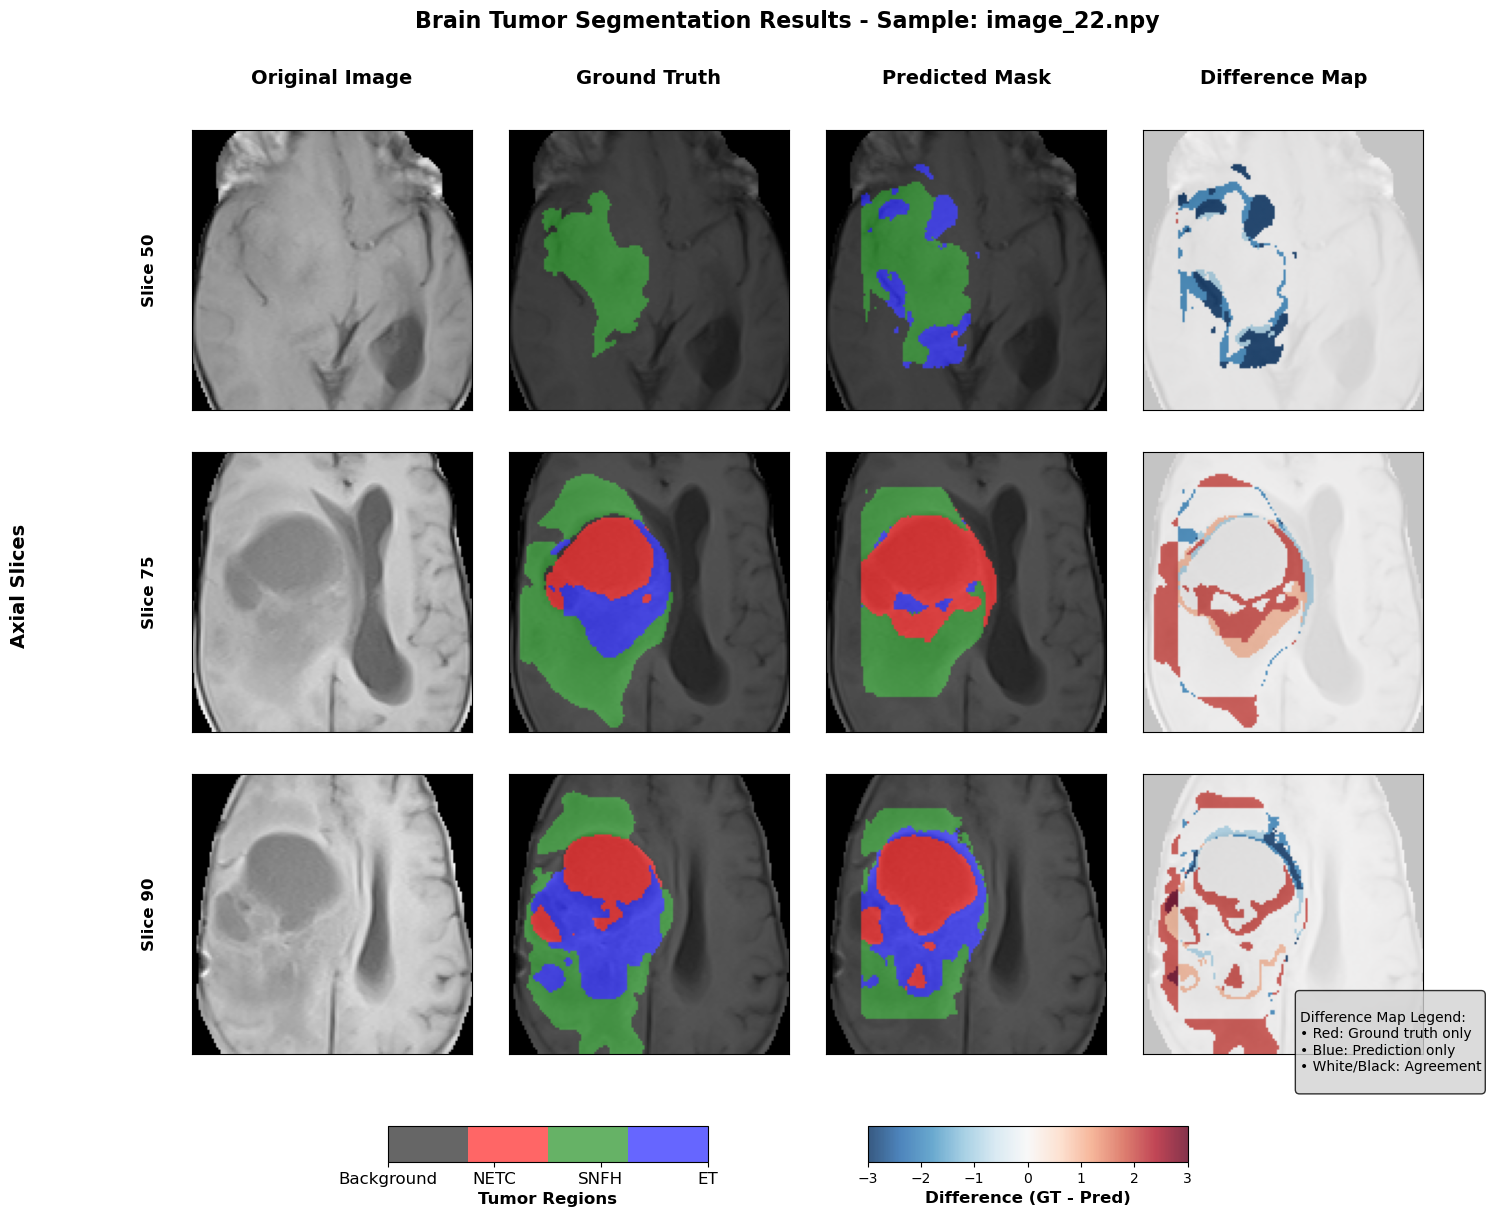


Visualization Statistics:
Original brain shape: (128, 128, 128, 4)
Patch size used for prediction: (96, 96, 96)
Slices displayed: [50, 75, 90]
Ground truth classes present: [0 1 2 3]
Predicted classes present: [0 1 2 3]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from matplotlib.colors import ListedColormap

# Load the trained model
model_path = "saved_model/3D_unet_100_epochs_2_batch_patch_training.keras"
model = load_model(model_path, compile=False)

# Data paths
DATA_ROOT = "glioma split data"
test_img_dir = os.path.join(DATA_ROOT, "test/images/")
test_mask_dir = os.path.join(DATA_ROOT, "test/masks/")

# Get a test sample
test_img_list = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.npy')])
test_mask_list = sorted([f for f in os.listdir(test_mask_dir) if f.endswith('.npy')])

# Load one test sample
sample_idx = 1  # Change this to visualize different samples
test_image = np.load(os.path.join(test_img_dir, test_img_list[sample_idx]))
test_mask = np.load(os.path.join(test_mask_dir, test_mask_list[sample_idx]))

# Define patch size (must match model input size)
patch_size = (96, 96, 96)

# Function to extract center patch
def extract_center_patch(volume, patch_size):
    """Extract center patch from a 3D volume"""
    start_x = (volume.shape[0] - patch_size[0]) // 2
    start_y = (volume.shape[1] - patch_size[1]) // 2
    start_z = (volume.shape[2] - patch_size[2]) // 2
    
    return volume[
        start_x:start_x + patch_size[0],
        start_y:start_y + patch_size[1],
        start_z:start_z + patch_size[2]
    ]

# Extract center patches - use full brain instead of patches for better visualization
# Only use patches for model prediction
image_patch = extract_center_patch(test_image, patch_size)
mask_patch = extract_center_patch(test_mask, patch_size)

# For visualization, use the full brain volumes
viz_image = test_image
viz_mask = test_mask

input_image = np.expand_dims(image_patch, axis=0)
prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction, axis=-1)[0]  

# Convert ground truth to class indices if it's one-hot encoded
if len(mask_patch.shape) == 4:  
    mask_patch = np.argmax(mask_patch, axis=-1)

if len(viz_mask.shape) == 4:
    viz_mask = np.argmax(viz_mask, axis=-1)

# Select specific slices to visualize
slice_numbers = [50, 75, 90]

# Create a colormap for the masks
colors = ['black', 'red', 'green', 'blue']  # 0: background, 1: NETC, 2: SNFH, 3: ET
cmap = ListedColormap(colors)

# Create the figure - adjusted for better text visibility
fig, axes = plt.subplots(3, 4, figsize=(16, 12), 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.15})
fig.suptitle(f'Brain Tumor Segmentation Results - Sample: {test_img_list[sample_idx]}', 
             fontsize=16, y=0.98, weight='bold')

# Define column titles
column_titles = ['Original Image', 'Ground Truth', 'Predicted Mask', 'Difference Map']

# Add column titles
for j, title in enumerate(column_titles):
    axes[0, j].text(0.5, 1.15, title, transform=axes[0, j].transAxes, 
                   fontsize=14, weight='bold', ha='center', va='bottom')

for i, slice_num in enumerate(slice_numbers):
    # Ensure slice number is within valid range
    if slice_num >= viz_image.shape[2] or slice_num < 0:
        slice_num = max(0, min(slice_num, viz_image.shape[2] - 1))
    
    # Get the slices from full brain
    img_slice = viz_image[:, :, slice_num, 0] if len(viz_image.shape) == 4 else viz_image[:, :, slice_num]
    gt_slice = viz_mask[:, :, slice_num]
    
    # For predicted mask, we need to map patch coordinates to full brain coordinates
    # Create a full-size prediction mask filled with zeros
    full_pred_mask = np.zeros(viz_image.shape[:3])
    
    # Calculate patch position in full brain
    start_x = (viz_image.shape[0] - patch_size[0]) // 2
    start_y = (viz_image.shape[1] - patch_size[1]) // 2
    start_z = (viz_image.shape[2] - patch_size[2]) // 2
    
    # Place the predicted patch in the full brain
    full_pred_mask[
        start_x:start_x + patch_size[0],
        start_y:start_y + patch_size[1],
        start_z:start_z + patch_size[2]
    ] = predicted_mask
    
    pred_slice = full_pred_mask[:, :, slice_num]
    
    # Rotate for proper orientation
    img_slice = np.rot90(img_slice)
    gt_slice = np.rot90(gt_slice)
    pred_slice = np.rot90(pred_slice)
    
    # Normalize image for better contrast
    img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
    
    # Apply contrast enhancement
    img_slice = np.power(img_slice, 0.7)  # Gamma correction for better visibility
    
    # Create difference map (ground truth - predicted)
    diff_slice = gt_slice.astype(float) - pred_slice.astype(float)
    
    # Row label
    axes[i, 0].text(-0.15, 0.5, f'Slice {slice_num}', transform=axes[i, 0].transAxes, 
                   fontsize=12, weight='bold', rotation=90, va='center', ha='center')
    
    # Column 1: Original Image with enhanced contrast
    axes[i, 0].imshow(img_slice, cmap='gray', vmin=0, vmax=1)
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 0].set_aspect('equal')
    
    # Column 2: Ground Truth overlay
    axes[i, 1].imshow(img_slice, cmap='gray', vmin=0, vmax=1)
    gt_display = axes[i, 1].imshow(gt_slice, cmap=cmap, vmin=0, vmax=3, alpha=0.6)
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 1].set_aspect('equal')
    
    # Column 3: Predicted Mask overlay
    axes[i, 2].imshow(img_slice, cmap='gray', vmin=0, vmax=1)
    pred_display = axes[i, 2].imshow(pred_slice, cmap=cmap, vmin=0, vmax=3, alpha=0.6)
    axes[i, 2].set_xticks([])
    axes[i, 2].set_yticks([])
    axes[i, 2].set_aspect('equal')
    
    # Column 4: Difference Map (NEW)
    diff_cmap = ListedColormap(['blue', 'black', 'white', 'red'])  # -3 to +3 range
    axes[i, 3].imshow(img_slice, cmap='gray', vmin=0, vmax=1)
    diff_display = axes[i, 3].imshow(diff_slice, cmap='RdBu_r', vmin=-3, vmax=3, alpha=0.8)
    axes[i, 3].set_xticks([])
    axes[i, 3].set_yticks([])
    axes[i, 3].set_aspect('equal')

# Add colorbars with better positioning and larger text
# Main colorbar for GT and Pred
cbar_ax1 = fig.add_axes([0.25, 0.02, 0.2, 0.03])  # Horizontal colorbar
cbar1 = fig.colorbar(gt_display, cax=cbar_ax1, orientation='horizontal', ticks=[0, 1, 2, 3])
cbar1.ax.set_xticklabels(['Background', 'NETC', 'SNFH', 'ET'], fontsize=12)
cbar1.set_label('Tumor Regions', fontsize=12, weight='bold')

# Difference map colorbar
cbar_ax2 = fig.add_axes([0.55, 0.02, 0.2, 0.03])  # Horizontal colorbar
cbar2 = fig.colorbar(diff_display, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Difference (GT - Pred)', fontsize=12, weight='bold')
cbar2.ax.tick_params(labelsize=10)

# Add text annotations for better understanding
fig.text(0.02, 0.5, 'Axial Slices', rotation=90, fontsize=14, weight='bold', 
         va='center', ha='center')

# Add legend for difference map
legend_text = """
Difference Map Legend:
• Red: Ground truth only
• Blue: Prediction only  
• White/Black: Agreement
"""
fig.text(0.82, 0.08, legend_text, fontsize=10, va='bottom', ha='left',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout(rect=[0.05, 0.08, 0.95, 0.95])
plt.show()

# Print some statistics
print(f"\nVisualization Statistics:")
print(f"Original brain shape: {viz_image.shape}")
print(f"Patch size used for prediction: {patch_size}")
print(f"Slices displayed: {slice_numbers}")
print(f"Ground truth classes present: {np.unique(viz_mask)}")
print(f"Predicted classes present: {np.unique(predicted_mask)}")